### Ahmad Mustapha Wali
#### Group 507

# Convolutional Neural Networks for Text Classification

In [20]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding, Input
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras import metrics

## Task I: Word-based CNN for Text Classification

### 1. Data

The dataset that we are going to use is the imdb dataset of movie reviews. These are labelled by sentiment (positive/negative). 

The reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). 

For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

More information regarding the dataset can be found in the official [Keras documentation](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification).


In [21]:
# 1. Load the data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


### 2. Preprocess the text data 

In this particular case, where we are using the imdb dataset there is no need to do all the traditional preprocessings that we normally do when dealing with NLP problems. Part of them are already done at this point.

  - Split the dataset in train and test (maybe also validation).
  - Tokenize and transform to integer index. Here we would need to: 
    - instantitate a *Tokenizer()* object, 
    - fit that object on the text on which we are training the model (use the *fit_on_texts()* method)
    - call *texts_to_sequences()* for both the training and the test text.

  - **Add padding to ensure that all vectors have the same dimensionality.** Note that this is the only pre-processing that needs to be done in the case of the imdb dataset that is ready to be imported from keras.

In [22]:
maxlen = 1000

# 2. Pad sequences
x_train = pad_sequences(x_train, maxlen)
x_test = pad_sequences(x_test, maxlen)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 1000)
x_test shape: (25000, 1000)


### 3. CNN Architecture

A very simple example of CNN architecture for text classification can be found [here](https://keras.io/examples/imdb_cnn/). Take a look in order to have an idea about how things should look like at this level.

A few other simple implementations: https://www.kaggle.com/jacklinggu/keras-mlp-cnn-test-for-text-classification/notebook.

Please note that if the dataset is too small and the complexity of the model is large, then the phenomenon of overfitting will be imminent and fast.

The model will look similar to what you have seen in the CNN for image classification (the first lab):

> **3.1.** Instantiate the model. Use the constructor of the Sequential class as you have done in the first laboratory.

> **3.2.** After creating the initial model, we need to populate it with the hidden layers:
- **3.2.1.** With text classification, the first layer is usually an **embedding layer** in which word indices that come from the input layer are converted to word vectors (word2vec). This is an important conversion which enables a more efficient and faster processing of textual data. Each word integer is mapped into a one dimensional vector of floats which captures its syntactical properties within the movie reviews text corpus. This subject may be covered in a little more depth in an upcoming laboratory. At the moment, a few insights have been introduced in the theoretical support for this lab and even more explanation can be found in the Tensorflow and Google code archives and other blogs:
  - https://code.google.com/archive/p/word2vec
  - https://www.tensorflow.org/tutorials/word2vec
  - https://www.youtube.com/watch?v=T8tQZChniMk&list=PLR2RxXcwFe533vpJhgiDOAONyRzj3lzbJ
  - http://colah.github.io/posts/2014-07-NLP-RNNs-Representations
- **3.2.2.** After the embedding layer, add a **dropout** layer with a probability of 0.4.
- **3.2.3.** Add a **CONV** layer with 128 filters, filter size 3, padding same, activation relu and stride 1. Since our word vectors are one dimensional, we only need 1-dim convolutions. Keras provides us with a built in method for doing it elegantly. Note that we need to specify a convolution kernel length and number of filters to use (nb_filter). More info about parameters and usage at: https://keras.io/layers/convolutional/
- **3.2.4.** Use **Max Pooling** after the CONV layer.
- **3.2.5.** Add another **CONV** layer, similar in terms of parameters with what we have at 3.2.3. The only difference is that here we are trying a different kernel size (5 to be more specific).
- **3.2.6.** Add a **Batch Normalization** layer. You can, of course, try to train the model without this layer, or with any other modification. Without this layer in particular, you are going to (probably) see a fair amount of overfitting.
- **3.2.7.** Use **Max Pooling** again.
- **3.2.8.** Add a Flatten layer.
- **3.2.9.** Add a dense layer with hidden_dims hidden units and activation relu.
- **3.2.10. Dropout** neurons with a probability of 0.5. Do this in order to add even more prvention of overfitting.
- **3.2.11.** Our output layer consists of one neuron. The sigmoid activation will produce a float number between 0 and 1. We can round it to 0 or 1 to conclude if the movie review is negative or positive, or we can interpret it as a fuzzy value of how much the review is positive or negative.

> **3.3.** Compile the model using binary crossentropy as loss, accuracy as metric and adam optimizer. These values for the parameters should be seen as a suggestion and you are more than welcome to use any other valid values and see how the behavior changes.

> **3.4.** Train (fit) the model on the training data, with the test set as validation data. Set shuffle to True. For this particular dataset,  one possible (decent) batch size is 64 and (maybe) 10 epochs should be enough in order to dive into the problem.

In [23]:
# Set parameters
max_features = 10000
batch_size = 64
embedding_dims = 100
filters = 128
ks = [3, 5, 5] # kernel_size
hidden_dims = 128
epochs = 10

def get_cnn_model_v1(): 
    # 3.1. Create the model, no layers yet
    model = Sequential()

    # 3.2. Add the layers (check out the work done in the previous lab)
    
    ########################################################################################
    # 3.2.1. Add an embedding layer which maps our vocab indices (max_features) into embedding_dims dimensions
    model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
    
    # 3.2.2. Dropout with a probability of 0.4
    model.add(Dropout(0.4))

    # 3.2.3. Add a Convolution1D layer, with 128 filters, kernel size ks[0], padding same, activation relu and stride 1
    model.add(Conv1D(filters, ks[0], padding='same', activation='relu'))

    # 3.2.4. Use max pooling after the CONV layer
    model.add(MaxPooling1D())

    # 3.2.5. Add a CONV layer, similar in properties to what we have above (3.2.3.) and kernel size 5
    model.add(Conv1D(filters, ks[1], padding='same', activation='relu'))
    
    # 3.2.6. Add a Batch Normalization layer in order to reduce overfitting
    model.add(BatchNormalization())

    # 3.2.7. Use max pooling again
    model.add(MaxPooling1D())

    # 3.2.8. Add a flatten layer
    model.add(Flatten())

    # 3.2.9. Add a dense layer with hidden_dims hidden units and activation relu
    model.add(Dense(hidden_dims, activation='relu'))

    # 3.2.10. Add a dropout layer with a dropout probability of 0.5 
    model.add(Dropout(0.5))

    # 3.2.11. We project onto a single unit output layer, and squash it with a sigmoid
    model.add(Dense(1, activation='sigmoid'))
    
    ##################################################################################

    # 3.3. Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    return model
  
model = get_cnn_model_v1()

# 3.4. Train (fit) the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), verbose=1, shuffle=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 100)         1000000   
                                                                 
 dropout_3 (Dropout)         (None, 1000, 100)         0         
                                                                 
 conv1d_6 (Conv1D)           (None, 1000, 128)         38528     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 500, 128)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 500, 128)          82048     
                                                                 
 batch_normalization_1 (Batc  (None, 500, 128)         512       
 hNormalization)                                      

### 4. Evaluate the model

Evaluate the loss and the metrics (in our case accuracy) by which the model is evaluated for both:

> **4.1.** **Training** - This should show a number around the value 0.96.

> **4.2.** **Test** - The accuracy on the test set should show a value around 0.87.

Even from the values above, can be seen the overfitting of the model.
And, again, the model (hyperparameters) and choices of functions, etc are only to show how you can implement a CNN for text classification. From here you can try all kinds of new configurations, network architectures and hyperparameters

In [24]:
# 4.1. Evaluate the accuracy and loss on the training set
loss, accuracy = model.evaluate(x_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))

# 4.2. Evaluate the accuracy and loss on the test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

782/782 [==============================] - 4s 6ms/step - loss: 0.0040 - accuracy: 0.9988
Training Accuracy: 0.9988
Testing Accuracy:  0.8811


### 5. Visualize accuracy

The following plots show the learning curves during training/test in terms of accuracy and loss.
As a bonus, time permitting or as a homework, try to improve these by changing the architecture of the CNN and the configuration.

In [25]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


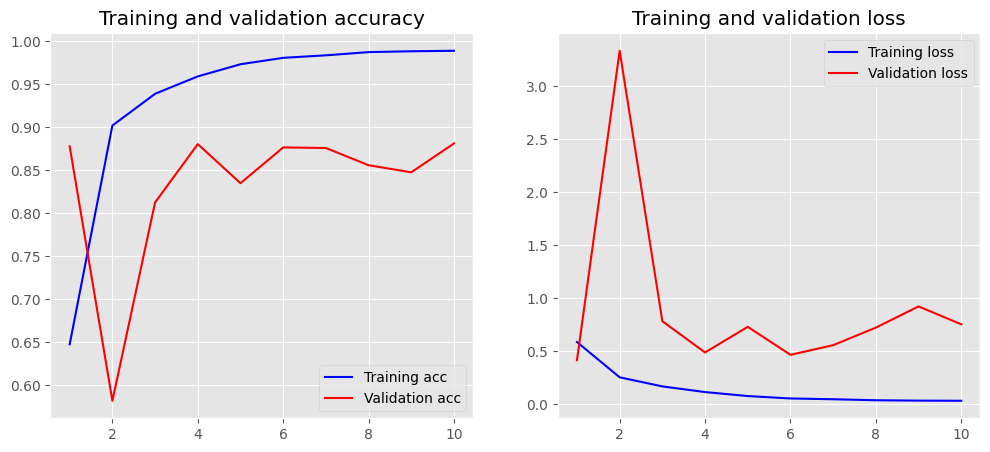

In [26]:
%matplotlib inline
plot_history(history)

### 6. Save/Load model

> 6.1. Exercise your knowledge on how to **save**

> 6.2. and **load** a model using the capabilities offered by the Keras framework.

In [27]:

from keras.models import load_model
filepath='C:\\Users\\Ahmad Wali\\Desktop\\Stuff\\Masters\\2nd Year\\1st Semester\\Deep Learning\\Lab2\\'
name = 'l2_m1'

# 6.1. Save the model
model.save(filepath+name)

# 6.2. Load the saved model
load_model(filepath+name)

INFO:tensorflow:Assets written to: C:\Users\Ahmad Wali\Desktop\Stuff\Masters\2nd Year\1st Semester\Deep Learning\Lab2\l2_m1\assets


INFO:tensorflow:Assets written to: C:\Users\Ahmad Wali\Desktop\Stuff\Masters\2nd Year\1st Semester\Deep Learning\Lab2\l2_m1\assets


## Task II: Character-based CNN for Text Classification

Time permitting, implement the character-based version of the CNN which is able to classify the movie reviews by sentiment.

You can have a look at the few implementations that can be found online. For example, this implementation is really similar with what has been implemented in the first paper where the problem of character-based CNN is formally tackled: https://github.com/chaitjo/character-level-cnn/blob/master/models/char_cnn_kim.py. 

However, keep in mind that for this particular dataset there are some modifications that need to be done. Your challenge is to discover those.

In [28]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding, Input
from keras.layers import Conv1D, MaxPooling1D
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import numpy as np

### 1. Restore the strings in the dataset
In this class, we have decided to use the imdb dataset from keras datasets. The only problem with this when trying to implement a character-based NN is that it has already performed the word2vec changes. This optimization, as we have seen in the Task I, is a really helpful one when implementing a word-based CNN. However this is not the case for a character based CNN, as we need to extract some information from the text, in order to be able to build the model.

> **1.1.** **Map IDs to words**
- **1.1.1.** Get the indexes corresponding to each word as per the imdb dataset (and module in keras). Hint: look up get_word_index().
- **1.1.2.** Shift with 3 the values in the word_to_id dictionary populated above. In other words, for key k, the value is going to be v + 3 instead of v now. We do this because the first 3 indexes are reserved for special symbols (see at the next step).
- **1.1.3.** Indexes 0-3 are now taken by the following special characters: "\<PAD>", "\<START>", "\<UNK>", "\<UNUSED>". Mark this by assigning the appropriate values to those keys.
- **1.1.4.** Reverse the roles in word_to_id. Build an id_to_word dictionary with the same content, and the difference that here the keys are the values from word_to_id and the values are the keys from that dictionary. We are doing this in order to ease the (re)conversion to text. 

> **1.2.** **Restore the text data**
- **1.2.1.** Get the corresponding words for the ids in the dataset. Use the function implemented following the steps above.
- **1.2.2.** For each sample (list of indexes corresponding to words in that review) in the dataset, perform the conversion to string, appending the words found at those indexes. Hint: use join() maybe and list comprehension.

> **1.3.** **Load the dataset** with only the top 5000 words.

> **1.4.** Restore both the training and test text


In [29]:
def map_ids_to_words():
    
    """
    1.1. Map ids to words
    
    This method returns a dictionary representing a mapping id -> word like 
    it is in the imdb dataset from keras datasets.
    
    """
    # 1.1.1. Get word indexes from the imdb dataset
    word_to_id = imdb.get_word_index()
    
    # 1.1.2. Shift with 3 (value + 3) the indexes in word_to_id
    word_to_id = {k:(v+3) for k,v in word_to_id.items()}
    
    # 1.1.3. Indexes 0-3 are now taken by the following special characters: "< PAD > ", "<START>", "<UNK>", "<UNUSED>".
    word_to_id["< PAD > "] = 0
    word_to_id["<START>"] = 1
    word_to_id["<UNK>"] = 2
    word_to_id["<UNUSED>"] = 3

    # 1.1.4. Reverse the roles in word_to_id (now the values become keys)
    id_to_word = {value:key for key,value in word_to_id.items()}
    
    return id_to_word

def restore_text_data(dataset):
   
    """
    1.2. Restore the text data.
    
    Use the method declared above to mapt the ids in the imdb representation to actual words.
    """
    str_data = []
    
    # 1.2.1. Get the corresponding words for the ids in the dataset.
    id_to_word = map_ids_to_words()
    
    # 1.2.2. For each sample in the dataset, perform the conversion to string
    for i in range(len(dataset)):
        str_data.append(' '.join(id_to_word[id] for id in dataset[i] ))
  
    print(str_data[0])
    
    return str_data

# 1.3. Load the dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=5000, index_from=3)

# 1.4. Restore text data for both training and test
X_train_str = restore_text_data(x_train)
X_test_str = restore_text_data(x_test)

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what they

### 2. Get the vocabulary
> **2.1.** Get the vocabulary - identify the set of characters ("vocabulary") for this dataset.

### 3. Create a Tokenizer

> **3.1.** Initialize the tokenizer. The important parameters here are:
- **char_level**=True: this can tell tk.texts_to_sequences() to process sentence in char level.
- **oov_token**='UNK': this will add a UNK token in the vocabulary. We can call it by tk.oov_token.
- **num_words**=None for starters.

> **3.2.** After calling tk.fit_on_texts(X_train_str), the tk object will contain the neccery information about the training data. 

> **3.3.** Build a character dictionary based on our alphabet (chars). 


In [30]:
# Maximum length for a sequence
maxlen = 1024 

def get_vocabulary(X_train_str):
    """
    2. Get the vocabulary.
    
    For each document in the dataset, for each symbol in that document, 
    append that symbol to txt.
    """
    txt = ''
    
    for word in X_train_str:
        for char in word:
            txt += char
    
    return set(txt)
  
def create_tokenizer(X_train_str, chars):
    """
    3. Create a Tokenizer.
    """
    # 3.1. Initialize the Tokenizer
    tk = Tokenizer(char_level=True, oov_token='UNK', num_words=None)

    # 3.2. Fit the tokenizer on the training data
    tk.fit_on_texts(chars)

    # 3.3. Build a character dictionary based on our alphabet (chars)
    char_dict = {}
    for i, char in enumerate(chars):
        char_dict[char] = i + 1

    # 3.4. Use char_dict to replace the tk.word_index
    tk.word_index = char_dict

    # 3.5. Add 'UNK' to the vocabulary 
    tk.word_index[tk.oov_token] = max(char_dict.values()) + 1
    
    return tk
    
chars = get_vocabulary(X_train_str)

tk = create_tokenizer(X_train_str, chars)

In [31]:
len(chars)

49

### 4. Yet another few preprocessings before building the actual model

> **4.1.** Conversions to be done for both the test/training text.
- **4.1.1.** Convert the strings in the text datasets to arrays of indexes. Hint: use texts_to_sequences().
- **4.1.2.** The sequences need to have the same length, so pad_sequences() until the maxlen of 1024.
- **4.1.3.** Convert to numpy array.

> **4.2.** One-hot encode the set of targets for the training.

> **4.3.** One-hot encode the set of targets for the test. Hint: to_categorical().

In [32]:
def preprocess_dataset(dataset, tk):
    """
    4.1. Conversions to be done for both the test/training text.
    """
    # 4.1.1. Convert string to index 
    sequences = tk.texts_to_sequences(dataset)

    # 4.1.2. Padding
    proc_data = pad_sequences(sequences, maxlen=1024)
    # 4.1.3. Convert to numpy array

    proc_data = np.array(proc_data)
    
    return proc_data

train_data = preprocess_dataset(X_train_str, tk)
test_data = preprocess_dataset(X_test_str, tk)

vocab_size = len(tk.word_index)

print("vocabulary: ", tk.word_index)
print("vocabulary size: ", vocab_size)

vocabulary:  {'p': 1, 'N': 2, 'f': 3, 'z': 4, 'T': 5, '2': 6, '9': 7, 'd': 8, 'S': 9, 'A': 10, '1': 11, '5': 12, 'c': 13, ' ': 14, '\x96': 15, 'x': 16, 'q': 17, '7': 18, 'm': 19, '0': 20, 'K': 21, 'l': 22, 'e': 23, '6': 24, 'o': 25, '4': 26, 'R': 27, 'n': 28, 's': 29, 'j': 30, 'h': 31, 'U': 32, '3': 33, '<': 34, 't': 35, 'g': 36, 'i': 37, '>': 38, 'v': 39, "'": 40, '8': 41, 'é': 42, 'u': 43, 'y': 44, 'w': 45, 'k': 46, 'a': 47, 'b': 48, 'r': 49, 'UNK': 50}
vocabulary size:  50


In [33]:
# 4.2. One-hot encode the training targets
y_train = to_categorical(y_train)

In [34]:
# 4.3. One-hot encode the test targets
y_test = to_categorical(y_test)

### 5. Load the Embedding Weights
In order to understand how to assign embedding weights to the embedding layer, here we initialize the embedding weights manually instead of initializing it randomly.

> **5.1.** **Append a zero vector** of size vocab_size, to represent the PAD. We can see, besides the 49 characters, we also have a UNK(unknown token) to represent the rare characters in vocabulary. Then we use the one-hot vector to represent these 50 characters, which means each character has 50 dimensions. Because Keras use 0 for PAD, we add a zero vector to represent PAD.

> **5.2.** One-hot encoding used for the embedding of the weights.

> **5.3.** Convert the embedding weights to numpy array.

In [35]:
def load_embedding_weights(tk, vocab_size):
    """
    5. Load manually the embedding weights.
    """
    embedding_weights = [] #(51, 50)

    #  5.1. Append zero vector to represent the PAD
    embedding_weights.append(np.zeros(vocab_size))
    
    # 5.2. One-hot repres of the characters
    for char, i in tk.word_index.items():
            onehot = np.zeros(vocab_size)
            onehot[i-1] = 1
            embedding_weights.append(onehot)

    #  5.3. Convert to a numpy array
    embedding_weights = np.array(embedding_weights)
    
    return embedding_weights
  
embedding_weights = load_embedding_weights(tk, vocab_size)

print("embedding weights shape: ", embedding_weights.shape)
print("embedding weights: \n", embedding_weights)

embedding weights shape:  (51, 50)
embedding weights: 
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


### 6. Build the model

> **6.1.** Instatiate the sequential model with no layers.

> **6.2.** Add an Embedding layer with vocab_size + 1, embedding_size, input_size as input_length and embedding_weights as weights.

> **6.3.** Add the convolutional layers having the \[filter_num, filter_size, pooling_size] specified in conv_layers. Note that if the pooling_size is -1, there is no pooling layer after that CONV. The activation function used is relu.

> **6.4.** Add a Flatten layer.

> **6.5.** Add one Fully connected layer with relu as activation and 1024 hidden units.

> **6.6.** Dropout half of the neurons.

> **6.7.** The output layer uses sigmoid as activation function and has 2 nodes.

> **6.8.** Compile the model with loss, optimizer and accuracy as metric.


In [36]:
input_size = 1024
embedding_size = 50
num_of_classes = 2
dropout_p = 0.5
optimizer = 'adam'
loss = "binary_crossentropy"

conv_layers = [[128, 7, 3], [128, 5, -1], [128, 3, -1], [128, 3, 3]]

def build_model_2():
    # 6.1. Instantiate the model
    model = Sequential()

    # 6.2. Add an Embedding layer 
    model.add(Embedding(vocab_size+1, embedding_size, input_length=input_size, weights=[embedding_weights]))
    
    # 6.3. Add the convolutional layers having the [filter_num, filter_size, pooling_size] specified in conv_layers
    for filter_num, filter_size, pooling_size in conv_layers:
        model.add(Conv1D(filter_num, filter_size, activation='relu'))

        #If pooling size != -1, add pooling layer
        if pooling_size != -1:
            model.add(MaxPooling1D(pool_size=pooling_size))
        
    # 6.4. Add a Flatten layer
    model.add(Flatten())

    # 6.5. Add one Fully connected layer of 1024 units
    model.add(Dense(input_size, activation='relu'))

    # 6.6. Dropout
    model.add(Dropout(dropout_p))

    # 6.7. Output layer
    model.add(Dense(2, activation='sigmoid'))
    
    # 6.8. Compile the model
    model.compile(optimizer=optimizer, metrics=['accuracy'], loss=loss)
    model.summary()
    
    return model
  
model2 = build_model_2()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1024, 50)          2550      
                                                                 
 conv1d_8 (Conv1D)           (None, 1018, 128)         44928     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 339, 128)         0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 335, 128)          82048     
                                                                 
 conv1d_10 (Conv1D)          (None, 333, 128)          49280     
                                                                 
 conv1d_11 (Conv1D)          (None, 331, 128)          49280     
                                                      

### 7. Train the model

We have experimented with batch size 128, 10 epochs and the train and validation (test_data) as parameters. Verbose should be 1 in order to follow how the training progresses.

In [38]:
# 7. Training
history2 = model2.fit(train_data, y_train, batch_size = 128, validation_data=(test_data, y_test), verbose=1, epochs=10)

Epoch 1/10
196/196 [==============================] - 18s 91ms/step - loss: 0.6923 - accuracy: 0.5116 - val_loss: 0.6910 - val_accuracy: 0.5047
Epoch 2/10
196/196 [==============================] - 18s 91ms/step - loss: 0.5639 - accuracy: 0.7011 - val_loss: 0.5135 - val_accuracy: 0.7465
Epoch 3/10
196/196 [==============================] - 18s 91ms/step - loss: 0.3914 - accuracy: 0.8251 - val_loss: 0.3412 - val_accuracy: 0.8515
Epoch 4/10
196/196 [==============================] - 18s 91ms/step - loss: 0.3193 - accuracy: 0.8626 - val_loss: 0.3188 - val_accuracy: 0.8609
Epoch 5/10
196/196 [==============================] - 18s 91ms/step - loss: 0.2805 - accuracy: 0.8807 - val_loss: 0.3764 - val_accuracy: 0.8349
Epoch 6/10
196/196 [==============================] - 18s 91ms/step - loss: 0.2506 - accuracy: 0.8951 - val_loss: 0.3119 - val_accuracy: 0.8665
Epoch 7/10
196/196 [==============================] - 18s 92ms/step - loss: 0.2040 - accuracy: 0.9169 - val_loss: 0.3517 - val_accuracy:

### 8. Evaluate the model

> **8.1.** Evaluate the accuracy and loss on the training set.

> **8.2.** Evaluate the accuracy and loss on the test set.

> **8.3.** Plot the learning curves.

In [40]:
# 8.1. Evaluate the accuracy and loss on the training set
loss, accuracy = model2.evaluate(train_data, y_train)
print("Training Accuracy: {:.4f}".format(accuracy))

# 8.2. Evaluate the accuracy and loss on the test set
loss, accuracy = model2.evaluate(test_data, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))

782/782 [==============================] - 6s 7ms/step - loss: 0.0471 - accuracy: 0.9890
Training Accuracy: 0.9890
782/782 [==============================] - 5s 7ms/step - loss: 0.4451 - accuracy: 0.8545
Testing Accuracy:  0.8545


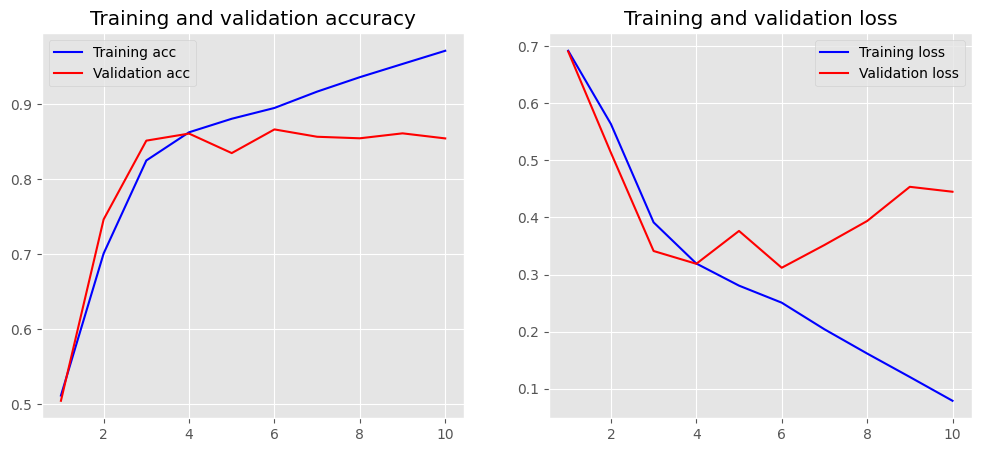

In [41]:
# 8.3. Plot the learning curves
%matplotlib inline
plot_history(history2)